In [1]:
import soundfile
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import os, glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
def preprocess_audio(file_path, sample_rate=22050, n_mfcc=13, n_fft=2048, hop_length=512):
    print(file_path)
    with soundfile.SoundFile(file_path, mode='rb') as f:
        audio = f.read(dtype='float32')
        
        # Convert mono to stereo if needed
        if len(audio.shape) > 1 and audio.shape[1] == 2:
            audio = np.mean(audio, axis=1)
        
        # Resample if needed
        if f.samplerate != sample_rate:
            audio = librosa.resample(y=audio, orig_sr=f.samplerate, target_sr=sample_rate)
        
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        stft = np.abs(librosa.stft(y=audio, n_fft=n_fft, hop_length=hop_length))
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)
        
        return chroma, mfccs, stft, mel_spectrogram

In [4]:
emotions = {
  '01': 'anger',
  '02': 'clear',
  '03': 'loud',
  '04': 'neutral',
  '05': 'slow',
}

observed_emotions = ['anger', 'clear', 'loud', 'neutral', 'slow']

In [5]:
def load_dataset():
    features = []
    labels = []
    for file in glob.glob("F:\\3Y-odd\\ML\\Project\\sph-stress\\speech_train\\*.sph"):
    # for path in data_paths:
        path = os.path.basename(file)
        print(path)
        emotion_label = emotions[path.split("-")[0]]  # Assuming emotion is in the filename
        if emotion_label not in observed_emotions:
            continue
        chroma, mfccs, stft, mel_spectrogram = preprocess_audio(file)
        combined_features = np.hstack((chroma.flatten(), mfccs.flatten(), stft.flatten(), mel_spectrogram.flatten()))
        features.append(combined_features)
        labels.append(emotion_label)
    
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return features, encoded_labels

In [8]:
features, labels = load_dataset()
padded_features = pad_sequences(features, padding='post', dtype='float32')
# features = np.array(features)
# encoded_labels = np.array(encoded_labels)

# Reshape the padded_features to match LSTM input
padded_features = padded_features.reshape(padded_features.shape[0], 1, padded_features.shape[1])

# Split dataset into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(padded_features, labels, test_size=0.2, random_state=42)


01-angry-01.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-01.sph
01-angry-02.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-02.sph
01-angry-03.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-03.sph
01-angry-04.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-04.sph
01-angry-05.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-05.sph
01-angry-06.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-06.sph
01-angry-07.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-07.sph
01-angry-08.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-08.sph
01-angry-09.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-09.sph
01-angry-10.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-10.sph
01-angry-11.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-11.sph
01-angry-12.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-12.sph
01-angry-13.sph
F:\3Y-odd\ML\Project\sph-stress\speech_train\01-angry-13.sph

In [9]:
print(padded_features.shape)
model = Sequential([
    LSTM(units=64, input_shape=(train_features.shape[1], train_features.shape[2]), return_sequences=True),
    LSTM(units=64),
    Dense(units=64, activation='relu'),
    Dense(units=len(np.unique(labels)), activation='softmax')  # Output layer with softmax for classification
])

(100, 1, 113088)


In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_features, train_labels, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 [==============================] - 1s 721ms/step - loss: 0.0655 - accuracy: 1.0000 - val_loss: 1.7581 - val_accuracy: 0.4375
Epoch 2/50
2/2 [==============================] - 1s 643ms/step - loss: 0.0597 - accuracy: 1.0000 - val_loss: 1.7754 - val_accuracy: 0.4375
Epoch 3/50
2/2 [==============================] - 1s 633ms/step - loss: 0.0546 - accuracy: 1.0000 - val_loss: 1.7923 - val_accuracy: 0.4375
Epoch 4/50
2/2 [==============================] - 1s 640ms/step - loss: 0.0499 - accuracy: 1.0000 - val_loss: 1.8107 - val_accuracy: 0.4375
Epoch 5/50
2/2 [==============================] - 1s 581ms/step - loss: 0.0463 - accuracy: 1.0000 - val_loss: 1.8404 - val_accuracy: 0.4375
Epoch 6/50
2/2 [==============================] - 1s 578ms/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 1.8589 - val_accuracy: 0.4375
Epoch 7/50
2/2 [==============================] - 1s 596ms/step - loss: 0.0397 - accuracy: 1.0000 - val_loss: 1.8813 - val_accuracy: 0.4375
Epoch 8/50
2/2 [====

In [16]:
loss, accuracy = model.evaluate(test_features, test_labels)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

1/1 [==============================] - 0s 68ms/step - loss: 3.7135 - accuracy: 0.3500
Test loss: 3.7134881019592285
Test accuracy: 0.3499999940395355


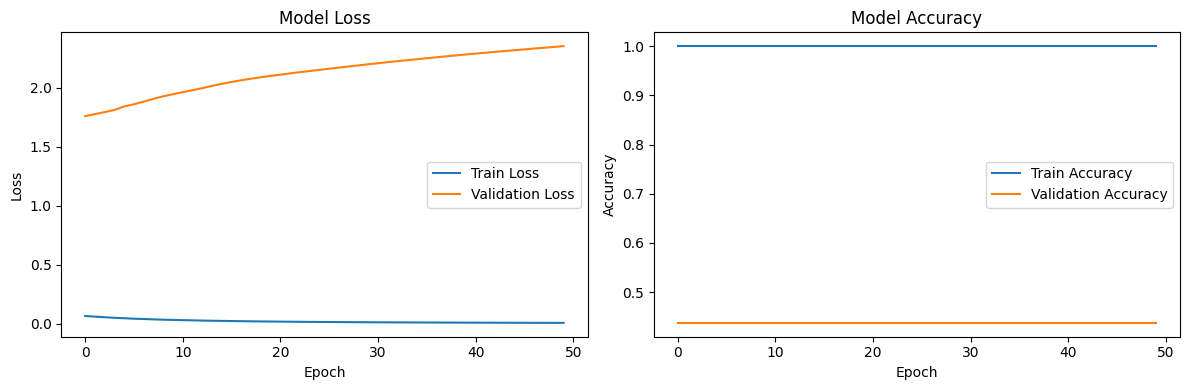

In [17]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()